<a href="https://colab.research.google.com/github/hududed/demo-mbo/blob/main/demo_mbo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup R in google colab

We first get the correct versions of `gdown` for a smooth setup. We can download pre-installed packages, untar them and set them as the new R library path.

In [ ]:
system("pip install --upgrade --no-cache-dir gdown", TRUE)
system("gdown 1sjoyDdPpAxLhzBlvuSjENvzJjUKsiSRZ", TRUE)
system("tar -xvf library.tar.gz", TRUE)
.libPaths("./usr/local/lib/R/site-library/")

Now we are able to load `mlr3` packages:

In [ ]:
library("mlr3extralearners")

In [ ]:
knitr::opts_chunk$set(warning = FALSE, message = FALSE) 
options(width = 100)

# "R6 basics for mlr3"

## Why mlr3?

It uses R6, that addresses shortcomings of earlier OO implementations e.g. S3 used in `mlr`.

## Quick R6 examples for beginners

If you have done any object-oriented programming before, R6 should feel familiar.


In [ ]:
library(R6)

Person <- R6Class("Person",
  public = list(
    name = NULL,
    hair = NULL,
    initialize = function(name = NA, hair = NA) {
      self$name <-name
      self$hair <- hair
      self$greet()
    },
    set_hair = function(val){
      self$hair <- val
    },
    greet = function(){
      cat(paste0("Hi, my name is ", self$name, ".\n"))
    }
  )
)

We instantiate the object with `$new()`. For example:

In [ ]:
hud <- Person$new("Hud", "black")
hud

Hi, my name is Hud.


<Person>
  Public:
    clone: function (deep = FALSE) 
    greet: function () 
    hair: black
    initialize: function (name = NA, hair = NA) 
    name: Hud
    set_hair: function (val) 

We can access the fields as such:

In [ ]:
hud$hair

[1] "black"

And set the argument:

In [ ]:
hud$hair = "blonde"
hud$hair

[1] "blonde"

## Quick `data.table` examples

Many `mlr3` functions return `data.table`s which can conveniently be subset or combined with other outputs.

The interface is similar to `data.frame()`:


In [ ]:
library(data.table)
dt = data.table(x = 1:6, y = rep(letters[1:3], each = 2))
dt

x,y
<int>,<chr>
1,a
2,a
3,b
4,b
5,c
6,c


`data.table`s can be used much like `data.frame`s, but they do provide additional functionality that makes complex operations easier. For example, data can be summarized by groups with the `[` operator:

In [ ]:
dt[, mean(x), by = "y"]

y,V1
<chr>,<dbl>
a,1.5
b,3.5
c,5.5


# mlr3 basics

## Overview

![ml_abstraction.svg](https://drive.google.com/uc?export=view&id=1-s6PPzpVSpxnSO_5yTdGsrLpj5WEml_8)

1.  Load data and creating tasks
2.  Data processing
3.  Creating learner objects
4.  Creating models
5.  Analysis



## Loading data

We will load the data `GOQ` adapted from the repo for our recent paper <https://github.com/aim-uwyo/lig-model-opt>, and preview the table:

In [ ]:
system("git clone https://github.com/hududed/demo-mbo", TRUE)

character(0)

In [ ]:
library(data.table)
library(mlr3)
library(mlr3learners)
library(mlr3viz)

d.goq <- subset(read.csv("demo-mbo/GOQ.csv", stringsAsFactors = TRUE), select = -c(campaign, initial))
head(d.goq, 5)

,power,time,gas,pressure,target
,<int>,<int>,<fct>,<int>,<dbl>
1,2170,1822,Argon,490,2.164596
2,2069,18445,Argon,830,1.311589
3,3063,4467,Argon,570,1.506055
4,4060,9988,Argon,270,1.749204
5,2678,4279,Argon,920,1.747806


We see that we have a mixed-variable inputs. We can also summarize the data as such:

In [ ]:
# summary(d.goq)
str(d.goq)

'data.frame':	210 obs. of  5 variables:
 $ power   : int  2170 2069 3063 4060 2678 3099 4431 5239 4585 5069 ...
 $ time    : int  1822 18445 4467 9988 4279 18787 3854 14517 14485 2735 ...
 $ gas     : Factor w/ 3 levels "Air","Argon",..: 2 2 2 2 2 2 2 3 3 3 ...
 $ pressure: int  490 830 570 270 920 910 270 230 1000 480 ...
 $ target  : num  2.16 1.31 1.51 1.75 1.75 ...


## Task

Tasks are objects that contain the (usually tabular) data and additional meta-data that defines a machine learning problem. The meta-data contains, for example, the name of the target feature for supervised machine learning problems. This information is used automatically by operations that can be performed on a task so that, e.g. the user does not have to specify the prediction target every time a model is trained.

Let's create our first task. Here we can define our inputs `backend` and objective `target`. This task specializes `Task` for regression problems. The target column is assumed to be numeric. The `task_type` is set to "regr".


In [ ]:
task_goq = TaskRegr$new(id = "GOQ", backend = d.goq, target = "target")
task_goq

<TaskRegr:GOQ> (210 x 5)
* Target: target
* Properties: -
* Features (4):
  - int (3): power, pressure, time
  - fct (1): gas

We can also define this task with `as_task_regr`, which converts the data object to a regression task `TaskRegr` :

In [ ]:
as_task_regr(d.goq, target="target")

<TaskRegr:d.goq> (210 x 5)
* Target: target
* Properties: -
* Features (4):
  - int (3): power, pressure, time
  - fct (1): gas

## Learner

Once we have the data loaded and a task defined. We can create a `Learner` object from the data.

Learners encapsulate methods to train a model and make predictions using it given a `Task` and provide meta-information about the learners. The base class of each learner is `Learner`.

What learners are there? let's have a look at what is inside the `mlr_learners` dictionary.

In [ ]:
mlr_learners
# as.data.table(mlr_learners)[task_type=="regr"]

<DictionaryLearner> with 121 stored values
Keys: classif.abess, classif.AdaBoostM1, classif.bart, classif.C50, classif.catboost,
  classif.cforest, classif.ctree, classif.cv_glmnet, classif.debug, classif.earth,
  classif.featureless, classif.fnn, classif.gam, classif.gamboost, classif.gausspr,
  classif.gbm, classif.glmboost, classif.glmer, classif.glmnet, classif.IBk,
  classif.imbalanced_rfsrc, classif.J48, classif.JRip, classif.kknn, classif.ksvm,
  classif.lda, classif.liblinear, classif.lightgbm, classif.LMT, classif.log_reg,
  classif.lssvm, classif.mob, classif.multinom, classif.naive_bayes, classif.nnet,
  classif.OneR, classif.PART, classif.priority_lasso, classif.qda, classif.randomForest,
  classif.ranger, classif.rfsrc, classif.rpart, classif.svm, classif.xgboost,
  dens.kde_ks, dens.locfit, dens.logspline, dens.mixed, dens.nonpar, dens.pen, dens.plug,
  dens.spline, regr.abess, regr.bart, regr.catboost, regr.cforest, regr.ctree,
  regr.cubist, regr.cv_glmnet, regr.debug, 

As we see there's about 120 different learner objects. Let's dive in one of them:

In [ ]:
# lrn_goq = lrn("regr.ranger")
lrn_goq = lrn("regr.ranger", max.depth=1)
lrn_goq
# mlr_learners_regr.ranger

<LearnerRegrRanger:regr.ranger>
* Model: -
* Parameters: num.threads=1, max.depth=1
* Packages: mlr3, mlr3learners, ranger
* Predict Types:  [response], se
* Feature Types: logical, integer, numeric, character, factor, ordered
* Properties: hotstart_backward, importance, oob_error, weights

So it allows various feature and predict types, and for convenience can allow weights or helpers to calculate feature importance, Out-of-bag errors, etc. Great!

What you might have caught is that we have also made the `Learner` object that we will train using random forest!

However, note that the `Model` is still empty - this means we have not trained our model yet!

![Overview of the different stages of a learner](https://drive.google.com/uc?export=view&id=1g15ZSaCZlBwkLh_8pnCC2UEyIF9yJtv-)

All learners work in two stages:

*Training*: The training task (features and target data) is passed to the learner's `$train()` function which trains and stores a model, i.e. the learned relationship of the features to the target.\
*Prediction*: The new data, usually a different partition of the original dataset, is passed to the `$predict()` method of the trained learner. The model trained in the first step is used to predict the target values, e.g. the numerical value for regression problems.

Note, a learner that has not been trained cannot make predictions and will throw an error if `$predict()` is called on it.

## Training the learner, building the model

We train the model by giving a task to the learner. The `mlr3::partition()` function randomly splits the task into two disjoint sets: a training set (67% of the total data, the default) and a test set (33% of the total data, the data not part of the training set). We learn a regression tree by calling the `$train()` method of the learner, specifying the task and the part of it to use for training (`splits$train`). This operation adds the learned model to the existing `mlr3::Learner` object. We can now access the stored model via the field `$model`.


In [ ]:
set.seed(12)
splits = partition(task_goq)
splits

$train
  [1]   3   4   5   8   9  12  13  14  15  16  17  19  20  21  23  25  27  28  29  32  34  36  39
 [24]  40  41  42  44  45  48  54  62  69  71  72  73  74  75  76  77  82  84  85  88  89  90  92
 [47]  93  95  97 102 112 113 114 117 120 121 130 131 140 143 144 145 146 148 150 152 153 155 156
 [70] 157 159 161 165 168 169 170 171 172 173 185 186 190 191 192 194 198 199 201 210   7  31  50
 [93]  51  52  53  56  58  59  60  64  65  67  68  70  78  79  80  98  99 101 103 104 106 108 111
[116] 127 174 175 179 180 181 184 189 195 197 200 204 205 208 109 122 123 128 129 134 135 136 137
[139] 176 178 182

$test
 [1]   1   2   6  10  11  18  22  24  26  30  33  35  37  38  43  46  47  49  55  57  61  81  83  86
[25]  87 115 118 139 141 142 147 149 151 154 158 160 162 163 164 166 167 188 196 209  63  66  91  94
[49]  96 100 105 107 110 116 119 138 177 187 193 202 203 206 207 124 125 126 132 133 183

In [ ]:
set.seed(12)
lrn_goq$train(task_goq, splits$train)
lrn_goq$model

Ranger result

Call:
 ranger::ranger(dependent.variable.name = task$target_names, data = task$data(),      case.weights = task$weights$weight, num.threads = 1L, max.depth = 1L) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      141 
Number of independent variables:  4 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        variance 
OOB prediction error (MSE):       1.387664 
R squared (OOB):                  0.3631366 

The results are not that great. The field `param_set` stores a description of the hyperparameters the learner has, their ranges, defaults, and current values:

In [ ]:
lrn_goq$param_set

<ParamSet>
                              id    class lower upper nlevels        default    parents value
 1:                        alpha ParamDbl  -Inf   Inf     Inf            0.5  splitrule      
 2:       always.split.variables ParamUty    NA    NA     Inf <NoDefault[3]>                 
 3:                      holdout ParamLgl    NA    NA       2          FALSE                 
 4:                   importance ParamFct    NA    NA       4 <NoDefault[3]>                 
 5:                   keep.inbag ParamLgl    NA    NA       2          FALSE                 
 6:                    max.depth ParamInt     0   Inf     Inf                               1
 7:                min.node.size ParamInt     1   Inf     Inf              5                 
 8:                     min.prop ParamDbl  -Inf   Inf     Inf            0.1                 
 9:                      minprop ParamDbl  -Inf   Inf     Inf            0.1  splitrule      
10:                         mtry ParamInt     1  

The set of current hyperparameter values is stored in the values field of the `param_set` field. You can access and change the current hyperparameter values by accessing this field, it is a named list:


In [ ]:
lrn_goq$param_set$values = list(max.depth=5, splitrule = "extratrees", num.random.splits=5)
lrn_goq$param_set$values

$max.depth
[1] 5

$splitrule
[1] "extratrees"

$num.random.splits
[1] 5

Now lets retrain the model.

In [ ]:
lrn_goq$train(task_goq, splits$train)
lrn_goq$model

Ranger result

Call:
 ranger::ranger(dependent.variable.name = task$target_names, data = task$data(),      case.weights = task$weights$weight, max.depth = 5L, splitrule = "extratrees",      num.random.splits = 5L) 

Type:                             Regression 
Number of trees:                  500 
Sample size:                      141 
Number of independent variables:  4 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         none 
Splitrule:                        extratrees 
Number of random splits:          5 
OOB prediction error (MSE):       0.751627 
R squared (OOB):                  0.6550435 

Now we see that the model has been trained using random forest `ranger`, and the results are slightly improved. Technically we can already predict something! Lets have a look:


In [ ]:
preds = lrn_goq$predict(task_goq, splits$test)
preds

<PredictionRegr> for 69 observations:
    row_ids    truth response
          1 2.164596 1.775072
          2 1.311589 1.272154
          6 1.587991 1.296299
---                          
        132 5.520003 4.626539
        133 7.210615 4.820495
        183 5.689906 3.334357

## Simple Analysis

The most common use of [mlr3viz](https://mlr3viz.mlr-org.com) is the `autoplot()` function, where the type of the object passed determines the type of the plot. Plotting types can be found by running `?autoplot.X`. For example, the documentation of plots for regression tasks can be found by running `?autoplot.TaskRegr`.


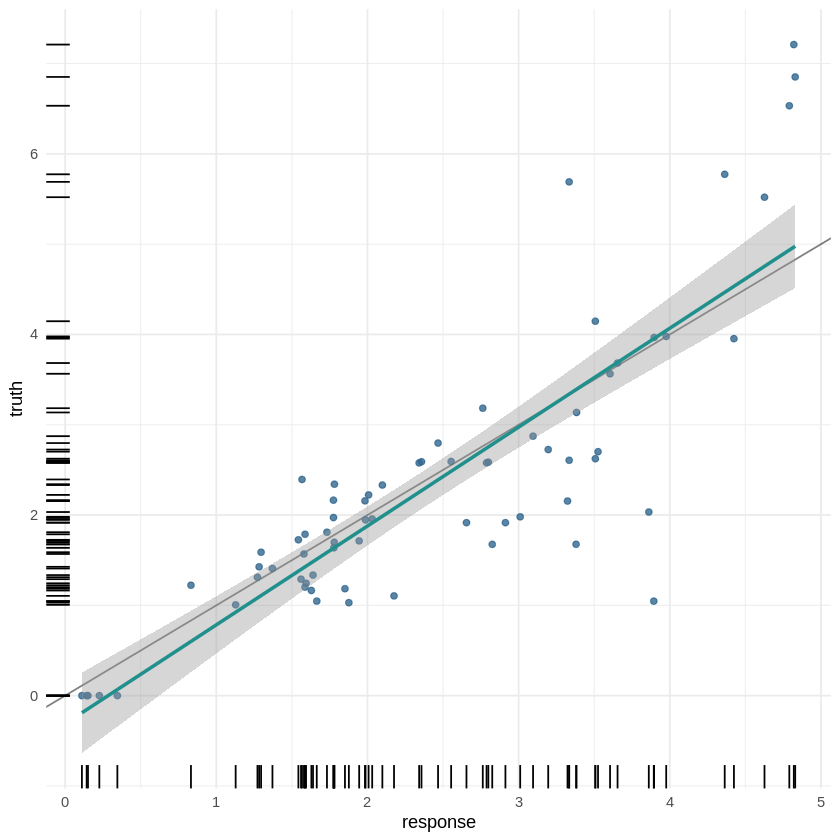

In [ ]:
autoplot(preds)

Installing package into ‘/content/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


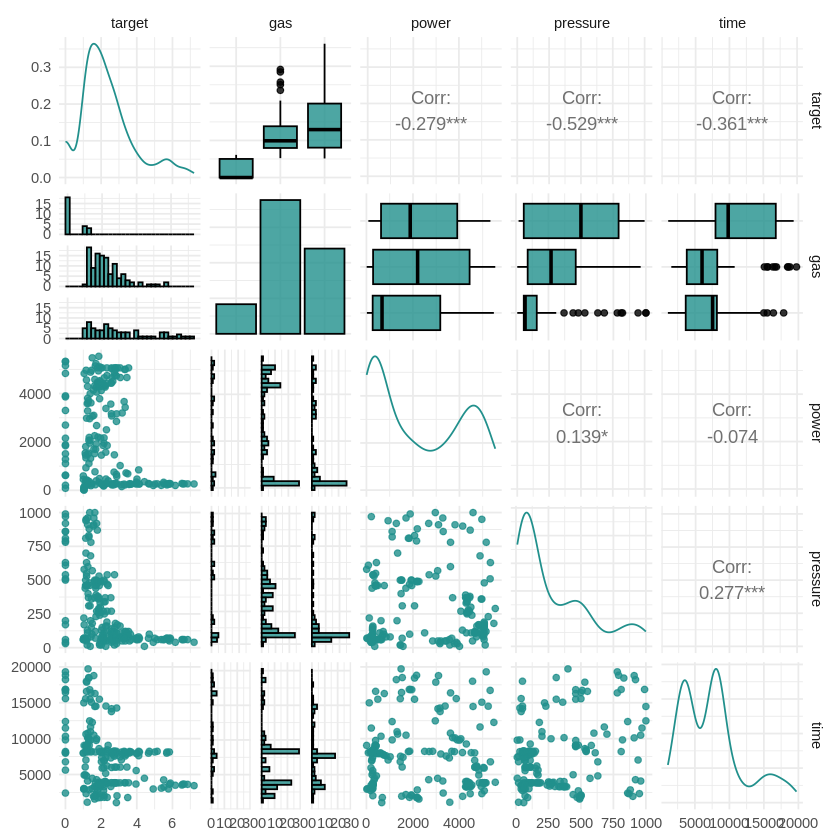

In [ ]:
# install.packages("GGally")
autoplot(task_goq, type = "pairs")

# mlr3mbo basics



![mbo schematic](https://drive.google.com/uc?export=view&id=1v9WO-OH6-2qmOpn0et0doSCkLB0UjkF8)

For further details, please visit the [mlr3mbo docs](https://mlr3mbo.mlr-org.com/index.html).

Generally, BO follows a simple loop:

1.  Fit the surrogate on all observations so far
2.  Optimize acquisition function to find the next promising candidate for evaluation
3.  Evaluate the next candidate

## MBO Building blocks

There are a few items we need to make `mlr3mbo` work.

1.  `loop_function`
2.  `surrogate`
3.  `acq_function`
4.  `acq_optimizer`

### Loop function

`loop_function` determines the behavior of the BO algorithm on a global level, i.e., how the subroutine should look like that is performed at each iteration.

To get an overview of readily available loop_functions, the following dictionary can be inspected:

In [ ]:
library(mlr3mbo)
library(mlr3tuning)
library(mlr3)
library(paradox)
as.data.table(mlr_loop_functions)

Loading required package: mlr3tuning

Loading required package: paradox



key,label,instance,man
<chr>,<chr>,<chr>,<chr>
bayesopt_ego,Efficient Global Optimization,single-crit,mlr3mbo::mlr_loop_functions_ego
bayesopt_mpcl,Multipoint Constant Liar,single-crit,mlr3mbo::mlr_loop_functions_mpcl
bayesopt_parego,ParEGO,multi-crit,mlr3mbo::mlr_loop_functions_parego
bayesopt_smsego,SMS-EGO,multi-crit,mlr3mbo::mlr_loop_functions_smsego


### Surrogate

A surrogate encapsulates a regression learner that models the unknown black box function based on observed data. In `mlr3mbo`, `SurrogateLearner` and `SurrogateLearnerCollection` are the higher-level R6 classes which should be used to construct a surrogate, inheriting from the base Surrogate class.

As a learner, any `LearnerRegr` from `mlr3` can be used, however, most acquisition functions require both a mean and a variance prediction (therefore not all learners are suitable for all scenarios). Typical choices include:

-   A `Gaussian Process` for low dimensional numeric search spaces
-   A `Random Forest` for higher dimensional mixed (and / or hierarchical) search spaces

A `SurrogateLearner` can be constructed via:

In [ ]:
library(mlr3learners)
surrogate = srlrn(lrn("regr.ranger"))
surrogate$model

<LearnerRegrRanger:regr.ranger>
* Model: -
* Parameters: num.threads=1
* Packages: mlr3, mlr3learners, ranger
* Predict Types:  response, [se]
* Feature Types: logical, integer, numeric, character, factor, ordered
* Properties: hotstart_backward, importance, oob_error, weights

### Acquisition Function

Based on a surrogate, an acquisition function quantifies the attractiveness of each point of the search space if it were to be evaluated in the next iteration.

To get an overview of available acquisition functions, the following dictionary can be inspected:

In [ ]:
as.data.table(mlr_acqfunctions)

key,label,man
<chr>,<chr>,<chr>
cb,Lower / Upper Confidence Bound,mlr3mbo::mlr_acqfunctions_cb
ei,Expected Improvement,mlr3mbo::mlr_acqfunctions_ei
eips,Expected Improvement Per Second,mlr3mbo::mlr_acqfunctions_eips
mean,Posterior Mean,mlr3mbo::mlr_acqfunctions_mean
pi,Probability Of Improvement,mlr3mbo::mlr_acqfunctions_pi
smsego,SMS-EGO,mlr3mbo::mlr_acqfunctions_smsego


Construction is straightforward via:

In [ ]:
acq_function = acqf("ei")
acq_function

<AcqFunctionEI:acq_ei>
Domain:
<ParamSet>
Empty.
Codomain:
<Codomain>
Empty.

`domain` and `Codomain` should contain something relating to the parameter set and target, respectively. But since lazy initialization is possible, we'll leave this there for now.


### Acquisition Function Optimizer

To find the most promising candidate for evaluation, the acquisition function itself must be optimized. Internally, an `OptimInstance` is constructed using the acquisition function as an `Objective.`

An acquisition function optimizer is then used to solve this optimization problem. Technically, this optimizer is a member of the `AcqOptimizer` R6 class.

Construction requires specifying an `Optimizer` as well as a `Terminator`:


In [ ]:
library(bbotk)
acq_optimizer = acqo(opt("random_search"), terminator = trm("evals"))

We can access the optimizer and terminator as such:

In [ ]:
acq_optimizer$optimizer

<OptimizerRandomSearch>: Random Search
* Parameters: batch_size=1
* Parameter classes: ParamLgl, ParamInt, ParamDbl, ParamFct
* Properties: dependencies, single-crit, multi-crit
* Packages: bbotk

In [ ]:
acq_optimizer$terminator

<TerminatorEvals>: Number of Evaluation
* Parameters: n_evals=100, k=0


Again, to access more detail on the optimizers`?mlr_optimizers`

aving introduced all building blocks we are now ready to put everything together in the form of an `OptimizerMbo`. Let's construct it:


In [ ]:
optimizer = opt("mbo",
  loop_function = bayesopt_ego,
  surrogate = surrogate,
  acq_function = acq_function,
  acq_optimizer = acq_optimizer)
optimizer

<OptimizerMbo>: Model Based Optimization
* Parameter classes: ParamLgl, ParamInt, ParamDbl, ParamFct
* Properties: single-crit
* Packages: mlr3mbo, mlr3, mlr3learners, ranger, bbotk
* Loop function: bayesopt_ego
* Surrogate: LearnerRegrRanger
* Acquisition Function: AcqFunctionEI
* Acquisition Function Optimizer: (OptimizerRandomSearch | TerminatorEvals)

### Putting it all together!

#### Single-objective: 2D Schwefel Function

In [ ]:
# ground truth function
objective_function = function(xs) {
  list(y = 418.9829 * 2 - (sum(unlist(xs) * sin(sqrt(abs(unlist(xs)))))))
}
# input parameter space and target
domain = ps(x1 = p_dbl(lower = -500, upper = 500),
  x2 = p_dbl(lower = -500, upper = 500))
codomain = ps(y = p_dbl(tags = "minimize"))
objective = ObjectiveRFun$new(
  fun = objective_function,
  domain = domain,
  codomain = codomain)
instance = OptimInstanceSingleCrit$new(
  objective = objective,
  search_space = domain,
  terminator = trm("evals", n_evals = 20))
# Gaussian Process, EI, DIRECT
surrogate = srlrn(lrn("regr.km",
  covtype = "matern3_2",
  optim.method = "gen",
  nugget.stability = 10^-8, control = list(trace = FALSE)))
acq_function = acqf("ei")
acq_optimizer = acqo(opt("nloptr", algorithm = "NLOPT_GN_DIRECT_L"),
  terminator = trm("stagnation", threshold = 1e-8))
optimizer = opt("mbo",
  loop_function = bayesopt_ego,
  surrogate = surrogate,
  acq_function = acq_function,
  acq_optimizer = acq_optimizer)
set.seed(2906)
optimizer$optimize(instance)

INFO  [22:26:12.025] [bbotk] Starting to optimize 2 parameter(s) with '<OptimizerMbo>' and '<TerminatorEvals> [n_evals=20, k=0]'
INFO  [22:26:12.115] [bbotk] Evaluating 8 configuration(s)
INFO  [22:26:12.145] [bbotk] Result of batch 1:
INFO  [22:26:12.148] [bbotk]         x1          x2         y
INFO  [22:26:12.148] [bbotk]   288.1638  472.053949  989.6333
INFO  [22:26:12.148] [bbotk]   112.2081  118.368684 1058.7716
INFO  [22:26:12.148] [bbotk]  -218.5212 -184.557119 1169.6945
INFO  [22:26:12.148] [bbotk]   312.1853  117.020492 1241.8801
INFO  [22:26:12.148] [bbotk]   337.1149    1.333371  995.0638
INFO  [22:26:12.148] [bbotk]   278.2793   13.156019 1074.2409
INFO  [22:26:12.148] [bbotk]   125.3826 -207.953753 1160.4590
INFO  [22:26:12.148] [bbotk]   262.1604 -264.520128  820.1803
WARN  [22:26:12.166] [bbotk] The 'rgenoud' package is required for optimization method 'gen'.
INFO  [22:26:12.168] [bbotk] surrogate_update_error / mbo_error / error / condition
INFO  [22:26:12.170] [bbotk]

x1,x2,x_domain,y
<dbl>,<dbl>,<list>,<dbl>
-291.4964,418.4985,"-291.4964, 418.4985",134.3886


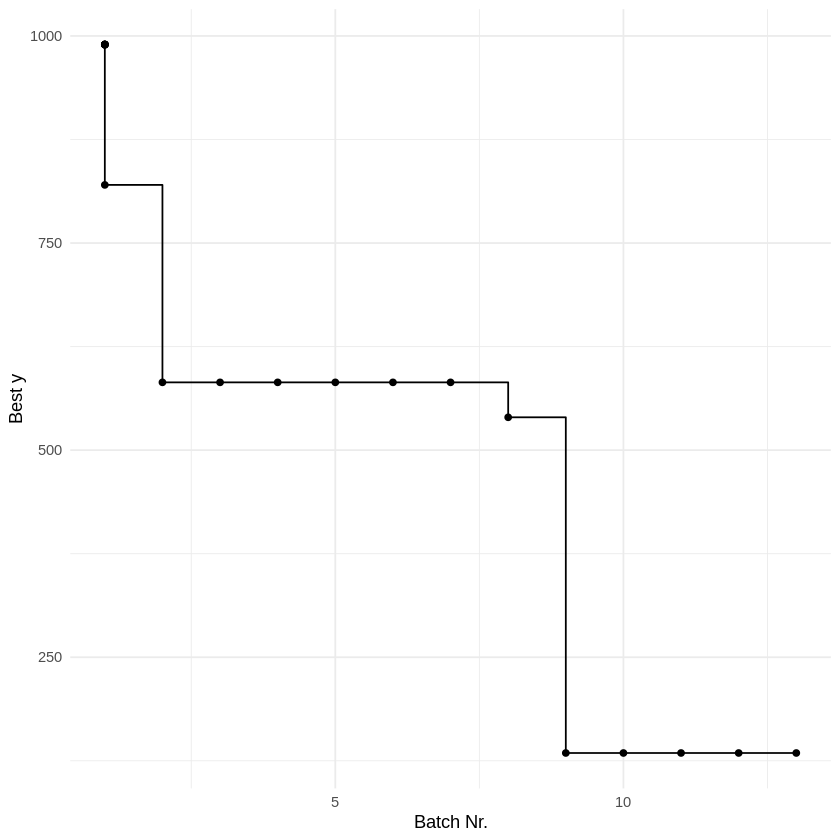

In [ ]:
library(ggplot2)
ggplot(aes(x = batch_nr, y = cummin(y)), data = instance$archive$data) +
  geom_point() +
  geom_step() +
  labs(x = "Batch Nr.", y = "Best y") +
  theme_minimal()

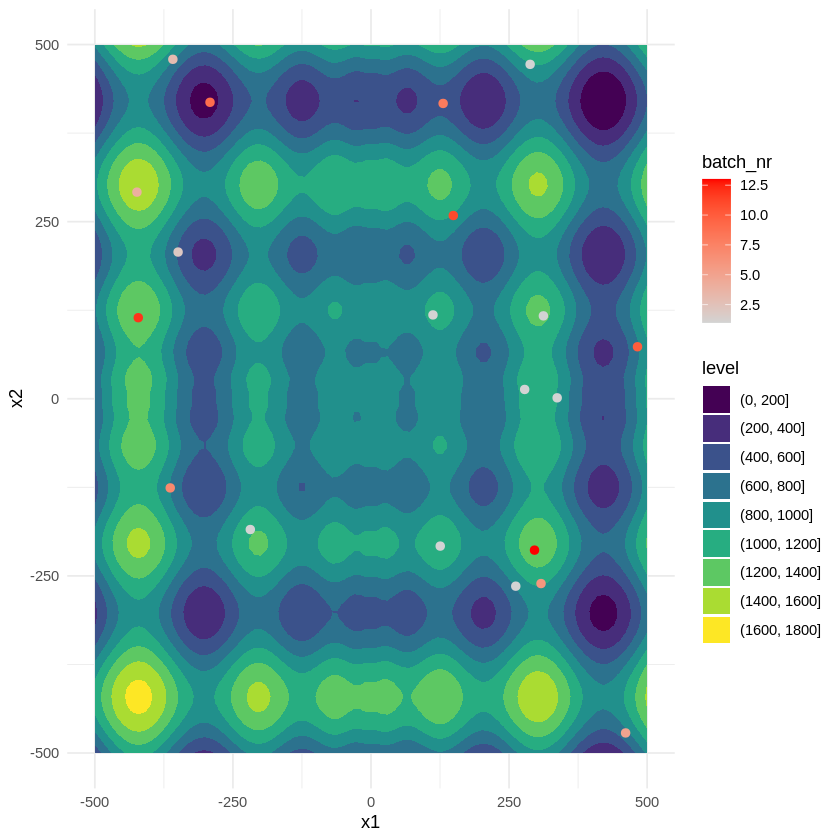

In [ ]:
xdt = generate_design_grid(instance$search_space, resolution = 101)$data
ydt = objective$eval_dt(xdt)
ggplot(aes(x = x1, y = x2, z = y), data = cbind(xdt, ydt)) +
  geom_contour_filled() +
  geom_point(aes(color = batch_nr), size = 2, data = instance$archive$data) +
  scale_color_gradient(low = "lightgrey", high = "red") +
  theme_minimal()

# mlr3 benchmarking

## Why benchmark?

[Benchmarking](https://mlr3book.mlr-org.com/performance.html#benchmarking) is used to compare the performance of different models, for example models trained with different learners, on different tasks, or with different resampling methods. This is usually done to obtain an overview of how different methods perform across different tasks. We cover how to


In [ ]:
library(ggplot2)
library(scales)
library(mlr3)
library(mlr3learners)
library(mlr3extralearners)
library(mlr3viz)
library(mlr3pipelines)

We first set the seed to allow reproducibility of the code.

In [ ]:
set.seed(123)

We can set the different learner models:

In [ ]:
# install.packages("kernlab")
learners = list(lrn("regr.featureless"),
                lrn("regr.lm"),
                lrn("regr.ranger"),
                lrn("regr.km", nugget.stability = 1e-8, covtype = "powexp"),
                lrn("regr.ksvm"),
                lrn("regr.rpart"))

Wrap each learner in a one-hot encoder for categorical features (gas)

In [ ]:
learners = lapply(learners, function(l) po("encode") %>>% po("learner", l))

Load the data and remove meta-data columns

In [ ]:

d.goq = subset(read.csv("demo-mbo/GOQ.csv", stringsAsFactors = TRUE), select = -c(campaign, initial))
task.goq = TaskRegr$new(id = "GOQ", backend = d.goq, target = "target")
d.gopi = subset(read.csv("demo-mbo/GOPI.csv", stringsAsFactors = TRUE), select = -c(campaign, initial))
task.gopi = TaskRegr$new(id = "GOPI", backend = d.gopi, target = "target")
d.pi = subset(read.csv("demo-mbo/PI.csv", stringsAsFactors = TRUE), select = -c(campaign, initial))
task.pi = TaskRegr$new(id = "PI", backend = d.pi, target = "target")

Run each learner on each task, with a 3-fold CV (to save time)

In [ ]:
design = benchmark_grid(
    tasks = list(task.goq, task.gopi, task.pi),
    learners = learners,
    resamplings = rsmp("cv", folds = 3)
)
bmr = benchmark(design)

INFO  [22:26:24.091] [mlr3] Running benchmark with 54 resampling iterations
INFO  [22:26:24.146] [mlr3] Applying learner 'encode.regr.featureless' on task 'GOQ' (iter 1/3)
INFO  [22:26:24.270] [mlr3] Applying learner 'encode.regr.featureless' on task 'GOQ' (iter 2/3)
INFO  [22:26:24.405] [mlr3] Applying learner 'encode.regr.featureless' on task 'GOQ' (iter 3/3)
INFO  [22:26:24.532] [mlr3] Applying learner 'encode.regr.lm' on task 'GOQ' (iter 1/3)
INFO  [22:26:24.976] [mlr3] Applying learner 'encode.regr.lm' on task 'GOQ' (iter 2/3)
INFO  [22:26:25.104] [mlr3] Applying learner 'encode.regr.lm' on task 'GOQ' (iter 3/3)
INFO  [22:26:25.227] [mlr3] Applying learner 'encode.regr.ranger' on task 'GOQ' (iter 1/3)
INFO  [22:26:25.432] [mlr3] Applying learner 'encode.regr.ranger' on task 'GOQ' (iter 2/3)
INFO  [22:26:25.645] [mlr3] Applying learner 'encode.regr.ranger' on task 'GOQ' (iter 3/3)
INFO  [22:26:25.868] [mlr3] Applying learner 'encode.regr.km' on task 'GOQ' (iter 1/3)

optimisation s

Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
“prediction from a rank-deficient fit may be misleading
This happened PipeOp regr.lm's $predict()”
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
“prediction from a rank-deficient fit may be misleading
This happened PipeOp regr.lm's $predict()”
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
“prediction from a rank-deficient fit may be misleading
This happened PipeOp regr.lm's $predict()”
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
“prediction from a rank-deficient fit may be misleading
This happened PipeOp regr.lm's $predict()”
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
“prediction from a rank-deficient fit may be misleading
This happened PipeOp regr.lm's $predict()”
Warning message in predict.lm(object = self$model, newdata = newd

INFO  [22:26:41.332] [mlr3] Finished benchmark


Again, if we want to know what kind of re-sampling is available:

In [ ]:
as.data.table(mlr_resamplings)

key,label,params,iters
<chr>,<chr>,<list>,<int>
bootstrap,Bootstrap,"ratio , repeats",30
custom,Custom Splits,,NA
custom_cv,Custom Split Cross-Validation,,NA
cv,Cross-Validation,folds,10
holdout,Holdout,ratio,1
insample,Insample Resampling,,1
loo,Leave-One-Out,,NA
repeated_cv,Repeated Cross-Validation,"folds , repeats",100
subsampling,Subsampling,"ratio , repeats",30


Then, we can output the `Benchmark` object with `autoplot` easily:

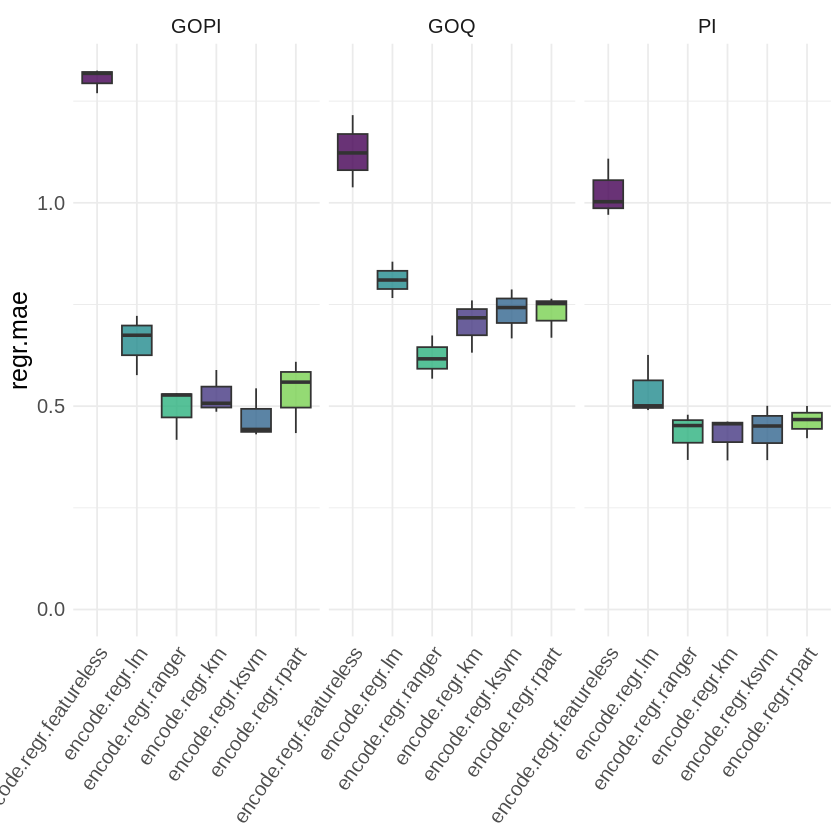

In [ ]:
autoplot(bmr, measure = msr("regr.mae")) +
    theme(text = element_text(size=15),
          axis.text.x = element_text(angle = 55, hjust = 1)) +
    expand_limits(y = 0)

In [ ]:
# install.packages("FSelectorRcpp")
library(mlr3filters)
filter = flt("information_gain")
filter$calculate(task_goq)

In [ ]:
as.data.table(filter)

feature,score
<chr>,<dbl>
pressure,0.2951373
gas,0.2420952
time,0.1813824
power,0.1244221


In [ ]:
keep = names(which(filter$scores > 0.2))
task_goq$select(keep)
task_goq$feature_names

[1] "gas"      "pressure"

# mlr3 further analysis


In [ ]:
lrn_goq = lrn("regr.ranger")
lrn_pi = lrn("regr.ranger")
lrn_gopi = lrn("regr.ranger")

In [ ]:
set.seed(12)
splits_goq = partition(task.goq)
splits_pi = partition(task.pi)
splits_gopi = partition(task.gopi)
lrn_goq$train(task.goq, splits_goq$train)
lrn_pi$train(task.pi, splits_pi$train)
lrn_gopi$train(task.gopi, splits_gopi$train)

## What more can we learn from the model?

Predictive models in R have different internal structures. To be able to analyse them systematically, we use a wrapper to provide a consistent interface for accessing the model. For models created with `mlr3`, we use the `DALEXtra::explain_mlr3()` function to parameterise the model created by the various frameworks (e.g. `explain_scikitlearn` or `explain_keras`, `?explain_<tab>` for further frameworks):


In [ ]:
library("DALEX")
library("DALEXtra")
set.seed(12)
explainer_goq = DALEXtra::explain_mlr3(lrn_goq,
  data = d.goq[splits_goq$test, ],
  y = d.goq[splits_goq$test, "target"],
  label = "Random Forest GOQ",
  colorize = FALSE)
explainer_pi = DALEXtra::explain_mlr3(lrn_pi,
  data = d.pi[splits_pi$test, ],
  y = d.pi[splits_pi$test, "target"],
  label = "Random Forest PI",
  colorize = FALSE)
explainer_gopi = DALEXtra::explain_mlr3(lrn_gopi,
  data = d.gopi[splits_gopi$test, ],
  y = d.gopi[splits_gopi$test, "target"],
  label = "Random Forest GOPI",
  colorize = FALSE)

Welcome to DALEX (version: 2.4.3).
Find examples and detailed introduction at: http://ema.drwhy.ai/
Additional features will be available after installation of: ggpubr.
Use 'install_dependencies()' to get all suggested dependencies

Anaconda not found on your computer. Conda related functionality such as create_env.R and condaenv and yml parameters from explain_scikitlearn will not be available



Preparation of a new explainer is initiated
  -> model label       :  Random Forest GOQ 
  -> data              :  69  rows  5  cols 
  -> target variable   :  69  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict function target column. (  default  )
  -> model_info        :  package mlr3 , ver. 0.14.1 , task regression (  default  ) 
  -> predicted values  :  numerical, min =  0.08592669 , mean =  2.509078 , max =  6.101675  
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  numerical, min =  -2.55549 , mean =  -0.178218 , max =  2.755048  
  A new explainer has been created!  
Preparation of a new explainer is initiated
  -> model label       :  Random Forest PI 
  -> data              :  69  rows  5  cols 
  -> target variable   :  69  values 
  -> predict function  :  yhat.LearnerRegr  will be used (  default  )
  -> predicted values  :  No value for predict fu

### Permutation Variable Importance

A popular technique for assessing variable importance in a model-agnostic manner is the variable importance. It is based on the difference (or ratio) in the selected loss function after the selected variable or set of variables has been permuted. Further reading in the [Variable-importance Measures](https://ema.drwhy.ai/featureImportance.html) chapter.

The `DALEX::model_parts()` function calculates the importance of variables and its results can be visualized with the generic `plot()` function.


In [ ]:
set.seed(12)
effect_goq = model_parts(explainer_goq)
effect_pi = model_parts(explainer_pi)
effect_gopi = model_parts(explainer_gopi)
head(effect_goq)

,variable,permutation,dropout_loss,label
,<chr>,<dbl>,<dbl>,<chr>
1,_full_model_,0,0.7765840,Random Forest GOQ
2,target,0,0.7765840,Random Forest GOQ
3,time,0,0.9278222,Random Forest GOQ
4,gas,0,1.0384111,Random Forest GOQ
5,power,0,1.0734209,Random Forest GOQ
6,pressure,0,1.2871522,Random Forest GOQ


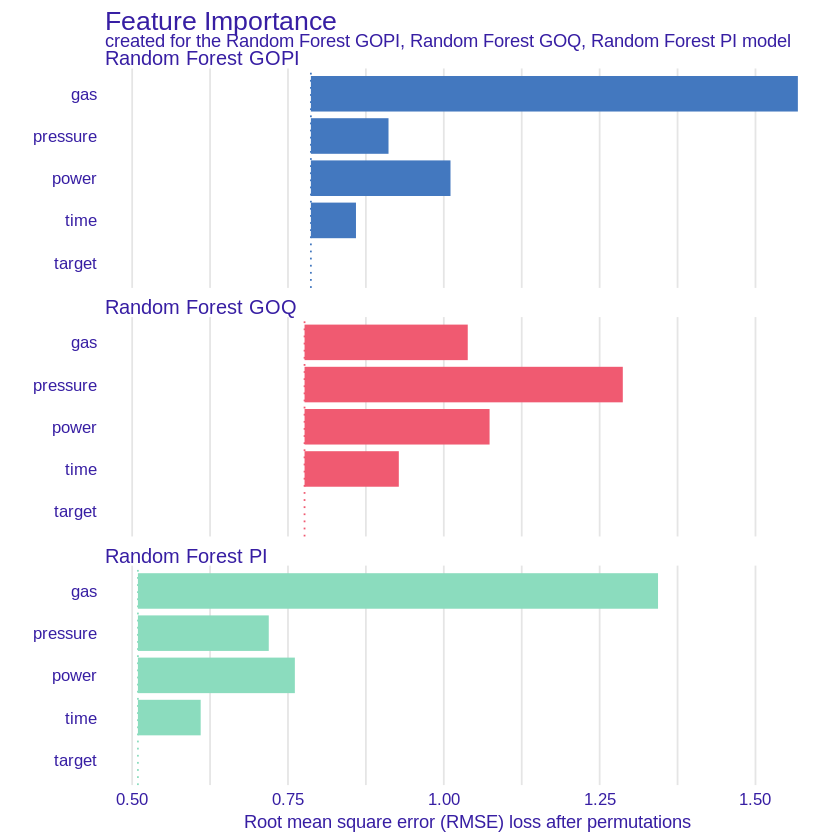

In [ ]:
plot(effect_goq, effect_pi, effect_gopi, show_boxplots = FALSE) 

The bars start in loss (here RMSE loss) for the selected data and end in a loss for the data after the permutation of the selected variable. The more important the variable, the more the model will lose after its permutation.

### Partial Dependence

Once we know which variables are most important, we can use [Partial Dependence Plots](https://ema.drwhy.ai/partialDependenceProfiles.html) to show how the model, on average, changes with changes in selected variables.

The `DALEX::model_profile()` function calculates the partial dependence profiles. Again, the result of the explanation can be model_profile with the generic function `plot()`.


In [ ]:
set.seed(12)
mp_goq = model_profile(explainer_goq)
mp_pi = model_profile(explainer_pi)
mp_gopi = model_profile(explainer_gopi)
mp_goq

In [ ]:
library(ggplot2)
plot(mp_goq, mp_pi, mp_gopi) + 
  theme(legend.position = "top") + 
  ggtitle("Partial Dependence for GOQ, PI, GOPI","")

In [ ]:
data_new = data.table(power = 250, time = 3500, gas = 'Argon', pressure = 50)

In [ ]:
goq_shap = predict_parts(explainer_goq, new_observation = data_new, 
             type = "shap")
plot(goq_shap, show_boxplots = FALSE) + 
             ggtitle("Shapley values for GOQ", "") 

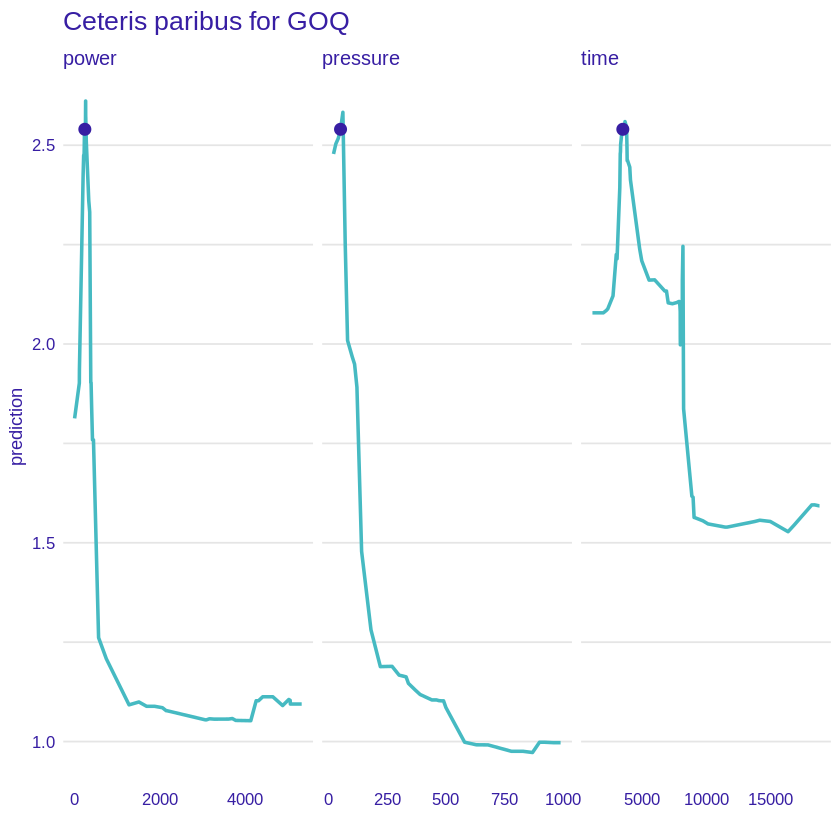

In [ ]:
goq_ceteris = predict_profile(explainer_goq, data_new)
plot(goq_ceteris) + ggtitle("Ceteris paribus for GOQ", " ") 